In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import public modules
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

# Import custom modules
from applications.molecules.src import utils
from applications.molecules.src import config_handling
from applications.molecules.src import plotting
from applications.molecules.src import factory

# Use latex-like font for figures
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family']      = 'STIXGeneral'

# Generate the figures directory if it does not exist yet
figures_dir_path = '../figures/'
utils.create_folder_if_inexistent(figures_dir_path)

[17:09:35] Initializing Normalizer


In [3]:
# Construct an orchestrator from a (trained) 'run folder'
run_folder_dir = '../trained/CTFM' # Could also be '../trained/DTDM' instead as their data preprocessing is the same
overrides = {
    'make_figs': False,
    'save_figs': False,
    'base_dir': '..',
}
config_handling.update_dirs_in_cfg(overrides, outputs_dir='./tmp', dont_update=['configs_dir', 'models_load_dir'])
print(f"Load the orchestrator from: {run_folder_dir}\n")
orchestrator = factory.Orchestrator.from_run_folder(run_folder_dir=run_folder_dir, overrides=overrides, load_data=True)
print(f"\nThe orchestrator has been loaded.")

Load the orchestrator from: ../trained/CTFM

Loaded the 'qmugs' preprocessed dataset from: ../data/preprocessed/qmugs_preprocessed_dataset.tsv
Maximum number of tokens (over all nswcs): 100
Unique tokens (#30): {'3', '6', 'N', '(', '+', 'I', ')', '1', 'l', '2', '[', 'B', 'P', '=', 'r', 'n', '#', '-', 'C', 'H', '5', '7', 'O', '4', 'c', 'F', 'S', 'o', ']', 's'}
#train: 488460
#validation: 122115
#train_logp: 488460
#train_num_heavy_atoms: 488460
#train_num_rings: 488460
Stack time to x as denoising model input: False
Using a normal predictor-guide model for 'num_rings'.
Stack time to x as num_rings-predictor model input: False
Stack time to x as logp-predictor model input: False
Stack time to x as num_heavy_atoms-predictor model input: False
Using the continuous-time framework (DFM for denoising model and DG for guidance).


The orchestrator has been loaded.


Number of starting molecules: 630508


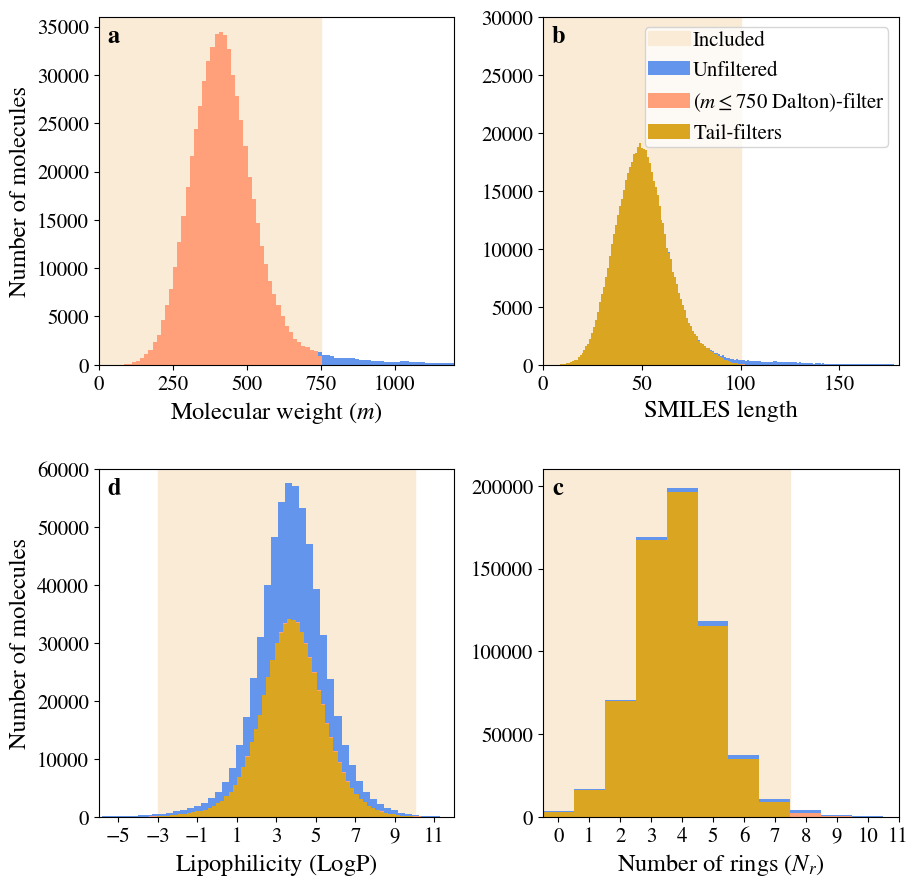

In [4]:
##########################################################################################
### Step 1: Define plot specifications
##########################################################################################
plot_specs = {
    'raw_color': 'cornflowerblue',
    'weight_filtered_color': 'lightsalmon',
    'extra_filtered_color': 'goldenrod',
    'boundary_color': 'silver',
    'within_boundaries_color': 'antiquewhite',
    'boundary_lw': 2,
    'raw_label': 'Unfiltered',
    'weight_filtered_label': r'($m\leq 750$ Dalton)-filter',
    'extra_filtered_label': 'Tail-filters',
    'alpha': 1.0,
    'fontsize': {
        'axis': 17.5,
        'ticks': 15,
        'leg': 15,
        'label': 17.5,
    },
    'x_lim': {
        'mol_weight': [0, 1200],
        'logp': [-6, 12],
        'num_tokens': [0, 180],
        'num_rings': [-0.5, 11],
    },
    'y_max': {
        'mol_weight': 36000,
        'logp': 60000,
        'num_tokens': 30000,
        'num_rings': 210000,
    },
    'y_lim_num_rings': 210000,
    'x_label': {
        'mol_weight': r'Molecular weight ($m$)',
        'num_tokens': 'SMILES length',
        'num_rings': r'Number of rings ($N_{r}$)',
        'logp': r'Lipophilicity ($\mathrm{LogP}$)',
    },
    'panel_labels': ['a', 'b', 'c', 'd'],
    'panel_x_rel': 0.025,
    'panel_y_rel': 0.975,
}


##########################################################################################
### Step 2: Load the dataset
##########################################################################################
raw_dataset_df = orchestrator.raw_dataset_df
print(f"Number of starting molecules: {len(raw_dataset_df)}")
filter_order      = orchestrator.molecules_data_handler.filter_order
filter_range_dict = orchestrator.molecules_data_handler.filter_range_dict
# Make a deepcopy of the raw dataset, so that the raw-dataset is not overwritten when filtering below:
dataset_df = raw_dataset_df.copy(deep=True)


##########################################################################################
### Step 3: Make the figure
##########################################################################################
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Filter the dataset, only keeping molecules with values in certain range
for counter, property_name in enumerate(filter_order):
    if property_name=='mol_weight':
        ax = axes[0, 0]
    elif property_name=='num_tokens':
        ax = axes[0, 1]
    elif property_name=='logp':
        ax = axes[1, 0]
    elif property_name=='num_rings':
        ax = axes[1, 1]
    else:
        pass

    # Check that the property name is a key of self.filter_range_dict and throw an error if it isn't
    if property_name not in filter_range_dict:
        err_msg = f"Cannot filter property '{property_name}' because it is not a key of 'self.filter_range_dict'."
        raise KeyError(err_msg)

    filter_range = filter_range_dict[property_name]
    
    # Check that property name corresponds to column of dataset_df
    if property_name not in dataset_df.columns:
        err_msg = f"Cannot filter on '{property_name}' because no column with this name is in dataset_df."
        raise ValueError(err_msg)
    
    # Check that the filter range contains a first element that is smaller than second
    if filter_range[1]<filter_range[0]:
        err_msg = f"The filter range for '{property_name}' contains second entry that is smaller than first entry, got filter range {filter_range}"
        raise ValueError(err_msg)

    # Make the histogram plot for the property distribution of the raw-dataset (without any filtering)
    _hist = plotting.custom_hist(raw_dataset_df[property_name], bins=115, color=plot_specs['raw_color'], histtype='stepfilled', label=plot_specs['raw_label'], ax=ax, alpha=plot_specs['alpha'])

    # Plot pre-filtering
    if property_name!='mol_weight':
        color = plot_specs['weight_filtered_color']
        label = plot_specs['weight_filtered_label']
        _hist = plotting.custom_hist(weight_filtered_df[property_name], bins=115, color=color, histtype='stepfilled', label=label, ax=ax, alpha=plot_specs['alpha'])

    # Filter the dataset
    dataset_df = dataset_df[(filter_range[0]<=dataset_df[property_name]) & (dataset_df[property_name]<=filter_range[1])]

    # Plot post-filtering
    if property_name=='mol_weight':
        weight_filtered_df = dataset_df.copy(deep=True)
        color = plot_specs['weight_filtered_color']
        label = plot_specs['weight_filtered_label']

    else:
        color = plot_specs['extra_filtered_color']
        label = plot_specs['extra_filtered_label']

    # Make the histogram plot for the property distribution of the (current) filtered dataset
    plotting.custom_hist(dataset_df[property_name], bins=_hist[1], color=color, histtype='stepfilled', label=label, ax=ax, alpha=plot_specs['alpha'])

    if property_name=='num_rings':
        #ax.vlines(filter_range[1]+0.5, 0, plot_specs['y_lim_num_rings'], color=plot_specs['boundary_color'], lw=plot_specs['boundary_lw'], ls='-', label='boundary(s)', zorder=1)
        ax.fill_between([filter_range[0]-0.5, filter_range[1]+0.5], plot_specs['y_max'][property_name], y2=0, color=plot_specs['within_boundaries_color'], zorder=-1, label='Included')
        ax.set_xticks(list(range(0, 12)))
        ax.set_ylim([0, plot_specs['y_max'][property_name]])
    else:
        #ax.vlines(filter_range[1], 0, plot_specs['y_max'][property_name], color=plot_specs['boundary_color'], lw=plot_specs['boundary_lw'], ls='-', label='Boundaries', zorder=1)
        ax.fill_between(filter_range, plot_specs['y_max'][property_name], y2=0, color=plot_specs['within_boundaries_color'], zorder=-1, label='Included')
        ax.set_ylim([0, plot_specs['y_max'][property_name]])
        if property_name=='logp':
            ax.set_xticks(list(range(-5, 12, 2)))

    if property_name in ['mol_weight', 'logp']:
        ax.set_ylabel('Number of molecules', fontsize=plot_specs['fontsize']['axis'])
    else:
        ax.set_ylabel('')

    # Set the plot specs of the current subplot
    ax.set_xlabel(plot_specs['x_label'][property_name], fontsize=plot_specs['fontsize']['axis'])
    ax.set_xlim(plot_specs['x_lim'][property_name])
    ax.tick_params(labelsize=plot_specs['fontsize']['ticks'])
    if property_name=='num_tokens':
        ax.legend(fontsize=plot_specs['fontsize']['leg'], loc='upper right', handletextpad=0.15, borderpad=0.15)

    # Set panellabel
    panel_label = plot_specs['panel_labels'][counter]
    panel_x_abs = plot_specs['x_lim'][property_name][0]+(plot_specs['x_lim'][property_name][1]-plot_specs['x_lim'][property_name][0])*plot_specs['panel_x_rel']
    panel_y_abs = 0+(plot_specs['y_max'][property_name]-0)*plot_specs['panel_y_rel']
    ax.text(panel_x_abs, panel_y_abs, panel_label, ha='left', va='top', fontsize=plot_specs['fontsize']['label'], fontweight='bold')


## Set the plot specs of the entire figure
# Adjust subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.3)

plt.show()


##########################################################################################
### Step 4: Save the figure as pdf
##########################################################################################
file_path = str(Path(figures_dir_path, 'appendix_data_preprocessing.pdf'))
fig.savefig(file_path, format='pdf', bbox_inches='tight')